<a href="https://colab.research.google.com/github/prodramp/DeepWorks/blob/main/DiffusionModels/Forward_Reverse_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebok is based on following Source Code: 

- https://github.com/acids-ircam/diffusion_models/blob/main/diffusion_02_model.ipynb


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Please get the file from 
from helper_plot import hdr_plot_style
hdr_plot_style()

In [3]:
from sklearn.datasets import make_swiss_roll
from sklearn.datasets import make_s_curve
from sklearn.datasets import make_moons

In [4]:
def display_source_data(data, s):
  # Plot it
  plt.figure(figsize=(8, 8))
  plt.scatter(*data, alpha=0.5, color='red', edgecolor='white', s=s);

In [5]:
size = 10**4
noise=0.5
# Sample a batch from the swiss roll
x, _= make_swiss_roll(size, noise=noise)
source_data_swiss_roll = x[:, [0, 2]] / 10.0
source_data_swiss_roll = source_data_swiss_roll.T

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


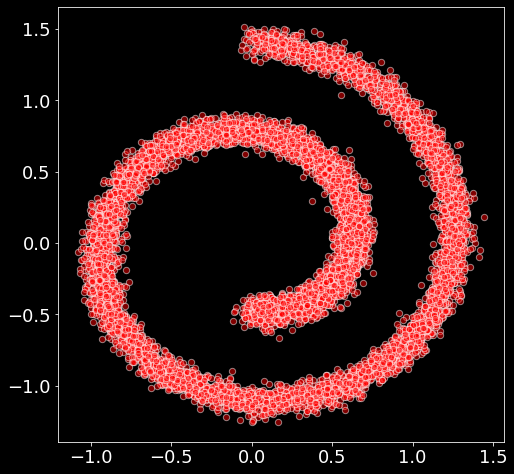

In [6]:
display_source_data(source_data_swiss_roll, 40)

In [11]:
## S-Curve
size = 10**4
noise=0.1
x, _= make_s_curve(size, noise=noise)
source_data_s_curve = x[:, [0, 2]]/10.0
source_data_s_curve = source_data_s_curve.T

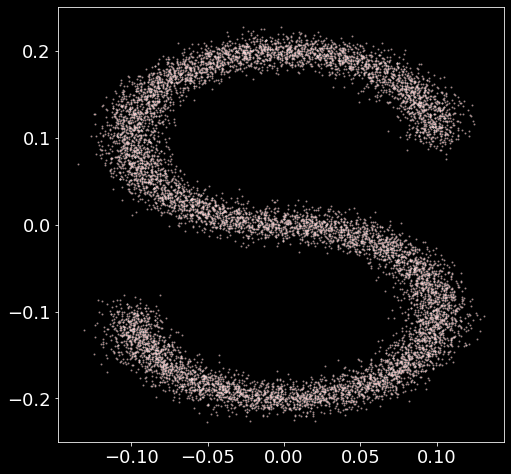

In [12]:
display_source_data(source_data_s_curve, 1)

In [20]:
## Moon
size = 10**4
noise=0.1
x, _= make_moons(size, noise=noise)
#source_data_moons = x[:, [0, 2]]/10.0
source_data_moons = x.T

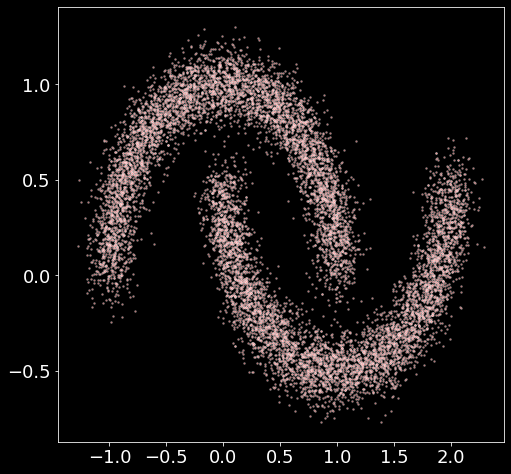

In [21]:
display_source_data(source_data_moons, 2)

In [22]:
## Set your source data
data = source_data_moons
print(type(data))

<class 'numpy.ndarray'>


In [23]:
data.shape

(2, 10000)

In [24]:
data

array([[ 1.16174169,  2.09449151,  0.23412419, ...,  0.81847034,
         1.6145722 ,  0.67059879],
       [-0.46260292,  0.2328013 ,  0.952221  , ..., -0.29372177,
        -0.18221489, -0.32946326]])

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Diffusion Model

## Simple Diffusion process with a constant variance schedule

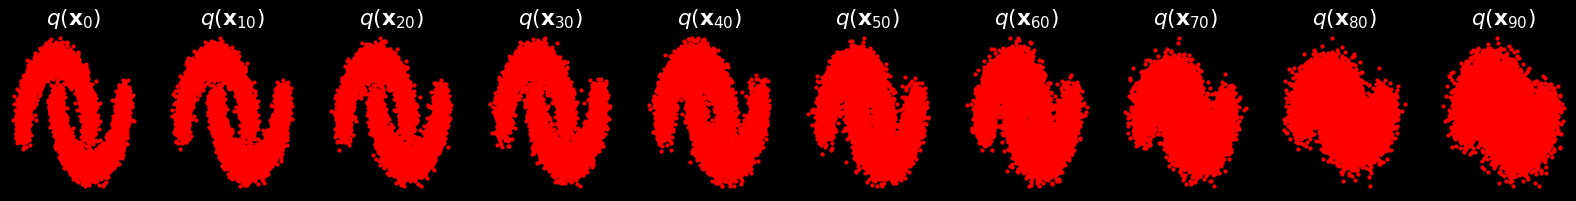

In [27]:
def forward_process(x_start, n_steps, noise=None):
    """ Diffuse the data (t == 0 means diffused for 1 step) """
    x_seq = [x_start]
    for n in range(n_steps):
        x_seq.append((torch.sqrt(1 - betas[n]) * x_seq[-1]) + (betas[n] * torch.rand_like(x_start)))
    return x_seq


n_steps = 100
betas = torch.tensor([0.035] * n_steps)
dataset = torch.Tensor(data.T).float()
x_seq = forward_process(dataset, n_steps, betas)
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    axs[i].scatter(x_seq[int((i / 10.0) * n_steps)][:, 0], x_seq[int((i / 10.0) * n_steps)][:, 1], s=10, color='red');
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(int((i / 10.0) * n_steps))+'})$')


## Dynamic Diffusion process with a Dynamic  variance schedules for B1.... Bn

In [28]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start=1e-5, end=1e-2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

In [29]:
betas = make_beta_schedule(schedule='sigmoid', n_timesteps=n_steps, start=1e-5, end=1e-2)
alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

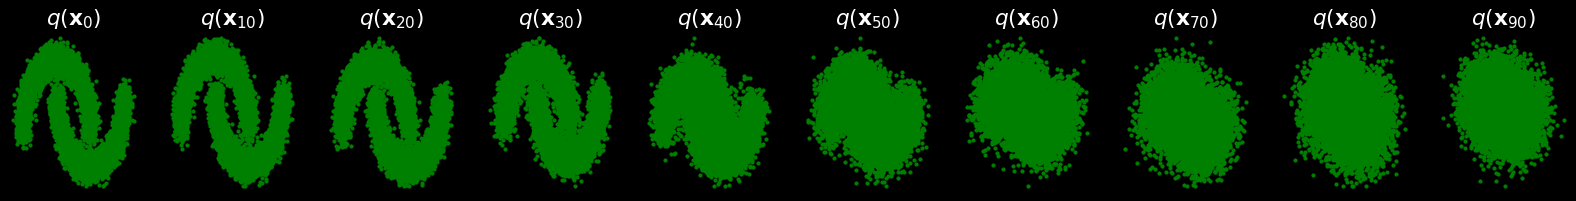

In [31]:
def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_sample(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_sample(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1], s=10, color='green');
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

## Model training
### Access to the mean and variance of the posterior distribution of this process.

In [32]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

## Reverse process

### A native implementation of this process, where we have a given model to infer variance. 

- This model is shared across all time steps but conditionned on that said time step.

In [33]:
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out

class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = nn.Linear(128, 4)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        return self.lin3(x)

model = ConditionalModel(n_steps)
    
def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

As we can see, the reverse process consists in inferring the values of the mean and log variance for a given timestep. Then, once we have learned the correponding model, we can perform the denoising of any given timestep, by providing both the sample 
 at a given time step, and that time step  that we can use to condition the models for 
 and 
.

In [34]:
def p_sample(model, x, t):
    mean, log_var = p_mean_variance(model, x, torch.tensor(t))
    noise = torch.randn_like(x)
    shape = [x.shape[0]] + [1] * (x.ndimension() - 1)
    nonzero_mask = (1 - (t == 0))
    sample = mean + torch.exp(0.5 * log_var) * noise
    return (sample) 

Finally, obtaining samples from the model is given by running through the whole Markov chain in reverse, starting from the normal distribution to obtain samples from the target distribution. 

Note that this process can be very slow if we have a large number of steps, as we need to wait for a given to infer the following 


In [35]:
def p_sample_loop(model, shape):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i)
        x_seq.append(cur_x)
    return x_seq

## Model Probability

In [36]:
def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def entropy(val):
    return (0.5 * (1 + np.log(2. * np.pi))) + 0.5 * np.log(val)

## Training loss

In [37]:
def compute_loss(true_mean, true_var, model_mean, model_var):
    # the KL divergence between model transition and posterior from data
    KL = normal_kl(true_mean, true_var, model_mean, model_var).float()
    # conditional entropies H_q(x^T|x^0) and H_q(x^1|x^0)
    H_start = entropy(betas[0].float()).float()
    beta_full_trajectory = 1. - torch.exp(torch.sum(torch.log(alphas))).float()
    H_end = entropy(beta_full_trajectory.float()).float()
    H_prior = entropy(torch.tensor([1.])).float()
    negL_bound = KL * n_steps + H_start - H_end + H_prior
    # the negL_bound if this was an isotropic Gaussian model of the data
    negL_gauss = entropy(torch.tensor([1.])).float()
    negL_diff = negL_bound - negL_gauss
    L_diff_bits = negL_diff / np.log(2.)
    L_diff_bits_avg = L_diff_bits.mean()
    return L_diff_bits_avg

In [38]:
def loss_likelihood_bound(model, x_0):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the loss
    return compute_loss(true_mean, true_var, model_mean, model_var)

## Optimize this loss with the following training loop.

In [39]:
model = ConditionalModel(n_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
dataset = torch.tensor(data.T).float()
batch_size = 128


In [40]:
def reverse_diffusion(model, optimizer, dataset, batch_size, color='red'):
  for t in range(5001):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = loss_likelihood_bound(model, batch_x)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()
    # Print loss
    if (t % 1000 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10, color=color);
            axs[i-1].set_axis_off(); axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')

tensor(197.6958, grad_fn=<MeanBackward0>)
tensor(-1.4220, grad_fn=<MeanBackward0>)
tensor(-2.9460, grad_fn=<MeanBackward0>)
tensor(1.7980, grad_fn=<MeanBackward0>)
tensor(1.8083, grad_fn=<MeanBackward0>)
tensor(1.5702, grad_fn=<MeanBackward0>)


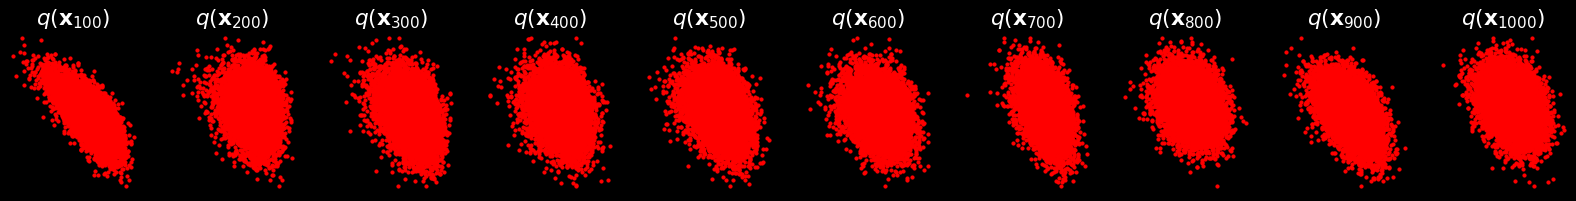

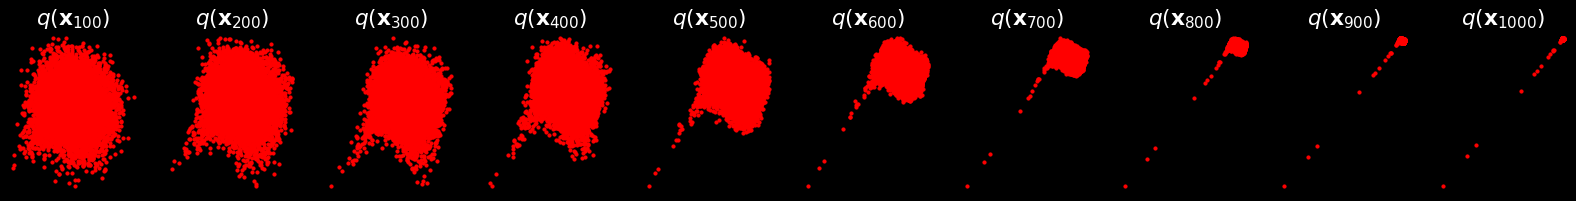

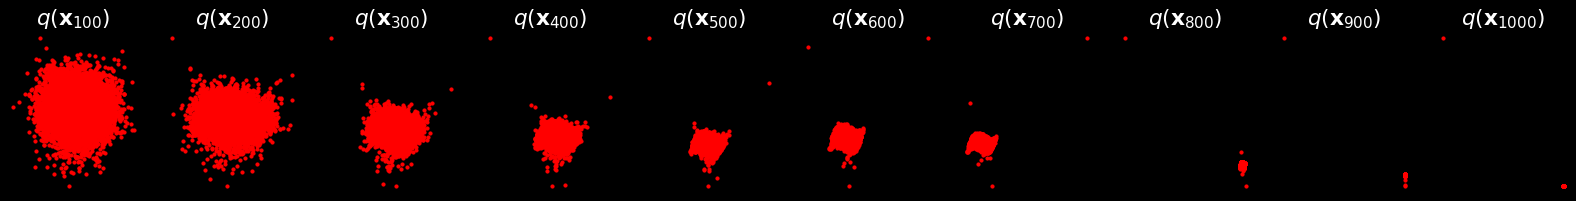

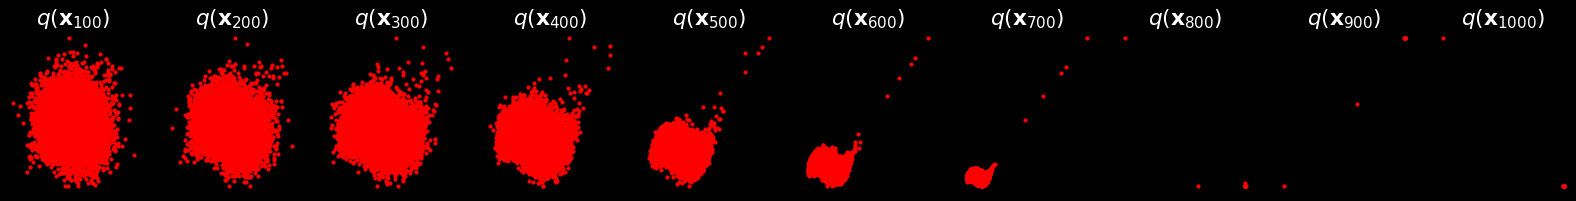

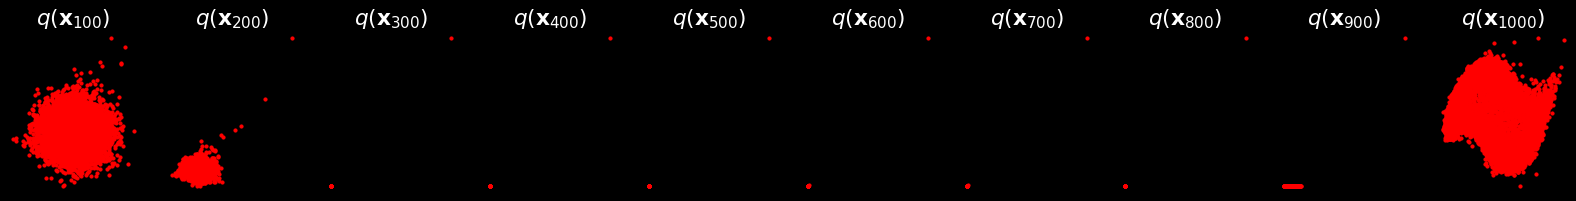

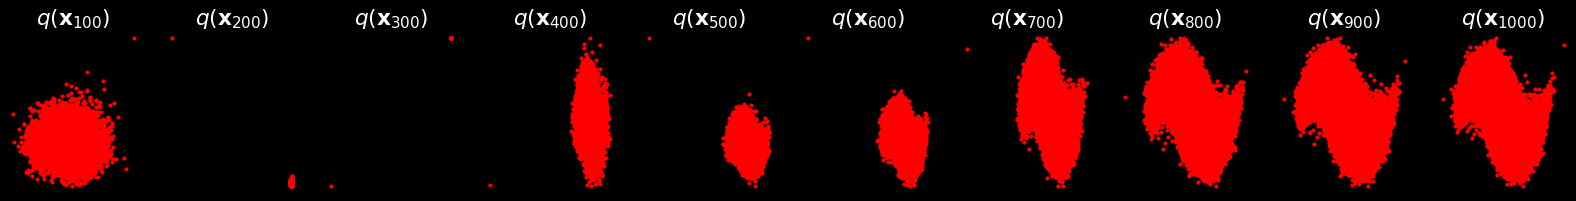

In [41]:
reverse_diffusion(model, optimizer, dataset, batch_size)